# Применение AutoML для соревнования "Richter's Predictor: Modeling Earthquake Damage"

В соревновании (https://www.drivendata.org/competitions/57/nepal-earthquake) предлагается предсказать уровань ущерба (1-3), который может причинить зданию землетрясение.

Для этой задачи классификации воспользуемся пакетом <a href="https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html">H2O</a> и в качестве бенчмарка возьмём классификаторы на основе градиентного бустинга(<a href="https://xgboost.readthedocs.io/en/latest/">XGBoost</a>) и случайного леса (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html" >RandomForestClassifier</a> из пакета <a href="https://scikit-learn.org">scikit-learn</a>).

# Классификация с использованием H2O

В начале импортируем пакет, смонтируем датасет и загрузим его во фрейм.

In [ ]:
#!pip install h2o

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os

base_path = "/content/drive/MyDrive/data/homework_nepal_earthquake/"
path_train_values = os.path.join(base_path,"train_values.csv")
path_train_labels = os.path.join(base_path,"train_labels.csv")
path_test_values = os.path.join(base_path,"test_values.csv")

Mounted at /content/drive


In [ ]:
import h2o
h2o.init()

train_values = h2o.import_file(path_train_values)
train_labels = h2o.import_file(path_train_labels)
train = train_values.merge(train_labels)

# Отмечаем ряд признаков как категориальные
for col in train.col_names:
  if col.startswith('has_') or col in ['land_surface_condition','foundation_type',
                                       'roof_type','ground_floor_type',
                                       'other_floor_type', 'position',
                                       'plan_configuration',
                                       'legal_ownership_status','damage_grade']:
    train[col] = train[col].asfactor()        

### Обучение модели H2O

In [ ]:
from h2o.automl import H2OAutoML
x = [c for c in train.columns if c not in ('building_id','damage_grade')]
y = 'damage_grade'

aml = H2OAutoML(max_models=5, seed=1)
aml.train(x=x, y=y, training_frame=train)

После обучения (на Google Colab длилось около 7 часов) посмотрим на таблицу победителей:

In [ ]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse,auc,aucpr
StackedEnsemble_AllModels_AutoML_20210729_134120,0.327657,0.56899,0.430811,0.185598,nan,nan
XGBoost_2_AutoML_20210729_134120,0.331515,0.595627,0.437763,0.191636,nan,nan
XGBoost_1_AutoML_20210729_134120,0.332397,0.579113,0.43413,0.188469,nan,nan
StackedEnsemble_BestOfFamily_AutoML_20210729_134120,0.336847,0.578614,0.435128,0.189336,nan,nan
XGBoost_3_AutoML_20210729_134120,0.346995,0.591711,0.440917,0.194408,nan,nan
DRF_1_AutoML_20210729_134120,0.395522,0.642526,0.464741,0.215985,nan,nan
GLM_1_AutoML_20210729_134120,0.666667,0.907063,0.575358,0.331037,nan,nan


Модель-победитель:

In [ ]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20210729_134120

No model summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.13202527374179654
RMSE: 0.3633528226693671

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.18559777865143245
RMSE: 0.43081060647508723


Сделаем предсказание и отправим submission для соревнования.

In [5]:
# Тестовые данные для submission
test_values = h2o.import_file(path_test_values)
test_x = [c for c in train.columns if c not in ('building_id',)]

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
predict = aml.leader.predict(test_values)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [ ]:
predict.head()

predict,p1,p2,p3
3,0.000810264,0.258586,0.740604
2,0.00212904,0.911074,0.0867966
2,0.0240983,0.818617,0.157285
1,0.653953,0.343577,0.00247063
3,0.00057164,0.22016,0.779269
2,0.0966327,0.641556,0.261812
1,0.623954,0.364154,0.0118923
3,7.71392e-05,0.0386191,0.961304
2,0.0380848,0.835434,0.126481
2,0.0566446,0.820454,0.122901


In [ ]:
# Сохраним модель (на Google Colab обучение длилось около 7 часов)
model_path = h2o.save_model(model=aml.leader, path=base_path, force=True)

In [55]:
saved_model = h2o.load_model(os.path.join(base_path,"StackedEnsemble_AllModels_AutoML_20210729_134120"))

In [ ]:
output_df = test_values[:,"building_id"].cbind(predict.rename(columns={"predict":"damage_grade"})[:,"damage_grade"])

In [ ]:
output_df.as_data_frame().to_csv(os.path.join(base_path,"submission.csv"),index=False)

После отправки получаем результат (в качестве метрики используется *micro averaged F1-score*):

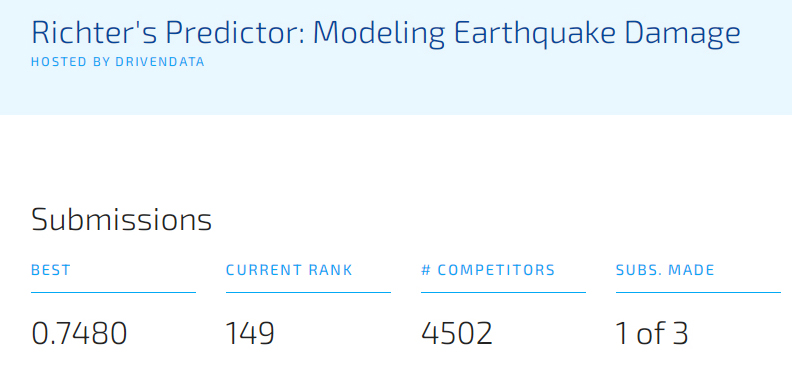

# Классификация с использованием XGBoost и RandomForestClassifier

Теперь сравним полученную модель с классификаторами XGBoost и RandomForestClassifier (все гиперпараметры - по умолчанию).

In [46]:
train_df = train.as_data_frame()
y = train_df['damage_grade']
X = train_df.drop(['building_id','damage_grade'],axis=1)

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.3,
    random_state=54321
)

In [48]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

В наборе данных есть символьные категориальные признаки - перекодируем их.

In [80]:
transformer_steps = [
    ('label', OrdinalEncoder(), ['land_surface_condition','foundation_type',
                                       'roof_type','ground_floor_type',
                                       'other_floor_type', 'position',
                                       'plan_configuration','legal_ownership_status']),
    ]

transformer = ColumnTransformer(transformer_steps, remainder='passthrough')

xgb_pipeline = Pipeline([
    ('transform', transformer),
    ('xgb', XGBClassifier())
])
rf_pipeline = Pipeline([
    ('transform', transformer),
    ('random_forest', RandomForestClassifier())
])

In [82]:
xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_test)

In [83]:
rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)

Вычислим метрику micro averaged F1 score для остальных моделей (тестовые данные получены перед обучением при помощи train_test_split):

In [98]:
print ('XGBoost: ',f1_score(y_test.values,xgb_preds,average='micro').round(3))
print ('Random Forest: ',f1_score(y_test.values,rf_preds,average='micro').round(3))

XGBoost:  0.676
Random Forest:  0.718


Вот какой результат дал RandomForest на <a href="https://www.drivendata.co/blog/richters-predictor-benchmark/">тестовых данных submission</a>: 

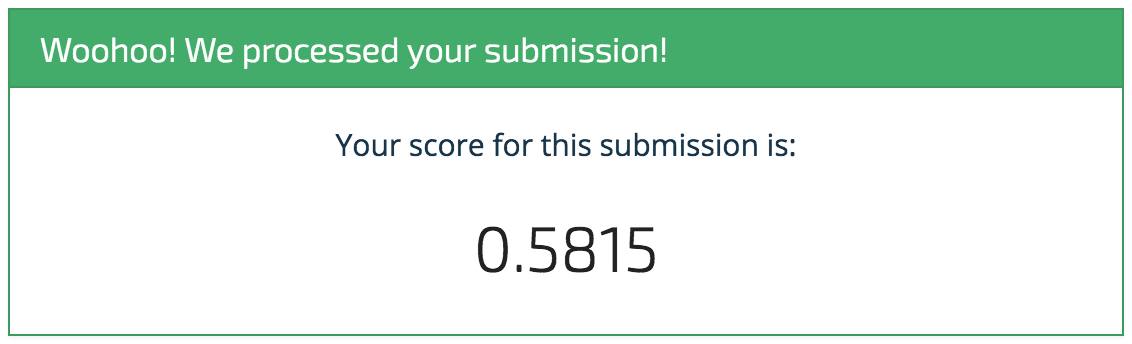

Полученная с помощью H2O AutoML модель показала гораздо лучшее качество, чем пара коробочных моделей с параметрами по умолчанию. Даже в соревновании первый же submission позволил нам попасть в топ-150 (из 4500) участников. Единственный недостаток - время обучения, но полученный результат с лихвой компенсирует эти трудности. В итоге мы получили вполне рабочую модель, которую можно улучшать дальше.